<a href="https://colab.research.google.com/github/BoboSamson/BoboSamson/blob/main/DistilBert_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
import pandas as pd

### 3. Get dataset & Data exploration


train_df = pd.read_csv("/content/train.csv")
display(train_df.head(5))
print(train_df.info())

test_df = pd.read_csv("/content/test.csv")
display(test_df.head(5))
print(test_df.info())


train_df["class"].unique()

test_df["class"].unique()

##train dataset looks fine but it seems test dataset contains some null classes.

test_df["class"].value_counts()


test_df.dropna(inplace=True)

#We need combine both the dataframe to make complete vocablury. We will use this combined dataframe letter during embedding.

combined_df = pd.concat([train_df, test_df], axis=0)
combined_df["class"].unique()

#Let's handle categorical classes,

label_map = {
    "figurative":0,
    "sarcasm":1,
    "irony":2,
    "regular":3
}

train_df['label'] = train_df['class'].map(label_map)
train_df.head(5)

test_df['label'] = test_df['class'].map(label_map)

,tweets,class
0,Be aware dirty step to get money #staylight ...,figurative
1,#sarcasm for #people who don't understand #diy...,figurative
2,@IminworkJeremy @medsingle #DailyMail readers ...,figurative
3,@wilw Why do I get the feeling you like games?...,figurative
4,-@TeacherArthurG @rweingarten You probably jus...,figurative


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81408 entries, 0 to 81407
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweets  81408 non-null  object
 1   class   81408 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None


,tweets,class
0,no one ever predicted this was going to happen...,figurative
1,@Stooshie its as closely related as Andrews or...,figurative
2,I find it ironic when Vegans say they love foo...,figurative
3,Quick rt that throwing money vine I've not see...,figurative
4,"yep, keep adding me to your #devops lists.... ...",figurative


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweets  8126 non-null   object
 1   class   8119 non-null   object
dtypes: object(2)
memory usage: 127.1+ KB
None


In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizer

class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer_name="distilbert-base-uncased", max_length=128):
        self.tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_name)
        self.texts = texts
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        # Tokenize text and convert into tensors
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),  # Remove batch dim
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }


In [ ]:
X = list(train_df['tweets'])
y = train_df['label'].to_numpy()


In [ ]:
# Extract text and labels
train_texts = train_df["tweets"].tolist()
train_labels = train_df["label"].tolist()

test_texts = test_df["tweets"].tolist()
test_labels = test_df["label"].tolist()

# Create dataset objects
train_dataset = TweetDataset(train_texts, train_labels)
test_dataset = TweetDataset(test_texts, test_labels)

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Train dataset size: 81408
Test dataset size: 8119


In [ ]:
from torch.utils.data import Dataset

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, SubsetRandomSampler

# Extract texts and labels from the train dataset (train_df)
train_texts = train_df["tweets"].tolist()
train_labels = train_df["label"].tolist()

# Create the TweetDataset for training
train_dataset = TweetDataset(train_texts, train_labels)

# Convert dataset to a list of indices for splitting
train_indices = list(range(len(train_dataset)))  # All indices in the train dataset

# Split into training & validation indices (75% train, 25% validation)
train_indices, val_indices = train_test_split(
    train_indices,
    test_size=0.25,  # 25% for validation
    random_state=2024,
    stratify=train_labels  # Ensure stratification based on labels for balanced distribution
)

# Print the sizes of the train and validation sets
print("Train dataset length:", len(train_indices))
print("Validation dataset length:", len(val_indices))

# Define samplers for DataLoader
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)

# Create DataLoaders for training and validation sets
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
validation_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=validation_sampler)

# Test dataset is handled separately as you already have the test_df
test_texts = test_df["tweets"].tolist()
test_labels = test_df["label"].tolist()

# Create the TweetDataset for test data
test_dataset = TweetDataset(test_texts, test_labels)

# Define test sampler
test_sampler = SubsetRandomSampler(range(len(test_dataset)))  # Use all indices for the test set

# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# Print the length of the test dataset
print("Test dataset length:", len(test_dataset))


Train dataset length: 61056
Validation dataset length: 20352
Test dataset length: 8119


In [ ]:
import torch
from transformers import DistilBertModel, DistilBertTokenizer
import torch.nn as nn

class DistilBertClassifier(nn.Module):
    def __init__(self, bert_model_name='distilbert-base-uncased', num_classes=4, hidden_size=768, dropout_prob=0.3, max_length=512):
        super(DistilBertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(512, num_classes)
        )
        self.tokenizer = DistilBertTokenizer.from_pretrained(bert_model_name)
        self.max_length = max_length

    def forward(self, input_ids, attention_mask):
        assert input_ids.shape[1] <= 512, f"Error: Sequence length too long ({input_ids.shape[1]} tokens)"

        input_ids = input_ids[:, :512]  # Ensure it never exceeds 512 tokens
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        pooled_output = torch.mean(outputs.last_hidden_state, dim=1)  # Average embeddings
        pooled_output = self.dropout(pooled_output)

        logits = self.classifier(pooled_output)
        return logits


In [ ]:
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model1: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch."""
    model1.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, data in enumerate(dataloader):
        if batch % 10 == 0:  # Print every 10 batches (adjust as needed)
            print(f"Processing train batch {batch}/{len(dataloader)}...")

        # Unpack the data from the dictionary
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        # 1. Forward pass
        y_pred = model1(input_ids, attention_mask)

        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, labels)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == labels).sum().item() / len(labels)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    print(f"train_step returning: train_loss = {train_loss}, train_acc = {train_acc}")
    return train_loss, train_acc

def test_step(model1: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch."""
    model1.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Loop through data loader data batches
    for batch_num, data in enumerate(dataloader):
        if batch_num % 10 == 0:  # Print progress every 10 batches
            print(f"Processing test batch {batch_num}/{len(dataloader)}...")

        # Unpack the data from the dictionary
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        # 1. Forward pass
        with torch.inference_mode():
            test_pred_logits = model1(input_ids, attention_mask)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, labels)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == labels).sum().item() / len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    print(f"test_step returning: test_loss = {test_loss}, test_acc = {test_acc}")
    return test_loss, test_acc

def train(model1, train_dataloader, test_dataloader, optimizer, loss_fn, scheduler, epochs, device):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    total_accu = None
    model1.to(device)

    for epoch in tqdm(range(epochs)):
        # Call train_step and unpack the return values
        train_loss, train_acc = train_step(model1=model1,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        print(f"train_step results: {train_loss}, {train_acc}")

        # Call test_step and unpack the return values
        test_loss, test_acc = test_step(model1=model1,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        print(f"test_step results: {test_loss}, {test_acc}")

        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

        if total_accu is not None and total_accu > test_acc:
            scheduler.step()
        else:
            total_accu = test_acc

        # Add results to dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model1 = DistilBertClassifier(num_classes=4).to(device)




model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:

loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
optimizer = torch.optim.RMSprop(model1.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)




  0%|          | 0/5 [00:00<?, ?it/s]

Processing train batch 0/477...
Processing train batch 10/477...
Processing train batch 20/477...
Processing train batch 30/477...
Processing train batch 40/477...
Processing train batch 50/477...
Processing train batch 60/477...
Processing train batch 70/477...
Processing train batch 80/477...
Processing train batch 90/477...
Processing train batch 100/477...
Processing train batch 110/477...
Processing train batch 120/477...
Processing train batch 130/477...
Processing train batch 140/477...
Processing train batch 150/477...
Processing train batch 160/477...
Processing train batch 170/477...
Processing train batch 180/477...
Processing train batch 190/477...
Processing train batch 200/477...
Processing train batch 210/477...
Processing train batch 220/477...
Processing train batch 230/477...
Processing train batch 240/477...
Processing train batch 250/477...
Processing train batch 260/477...
Processing train batch 270/477...
Processing train batch 280/477...
Processing train batch 29

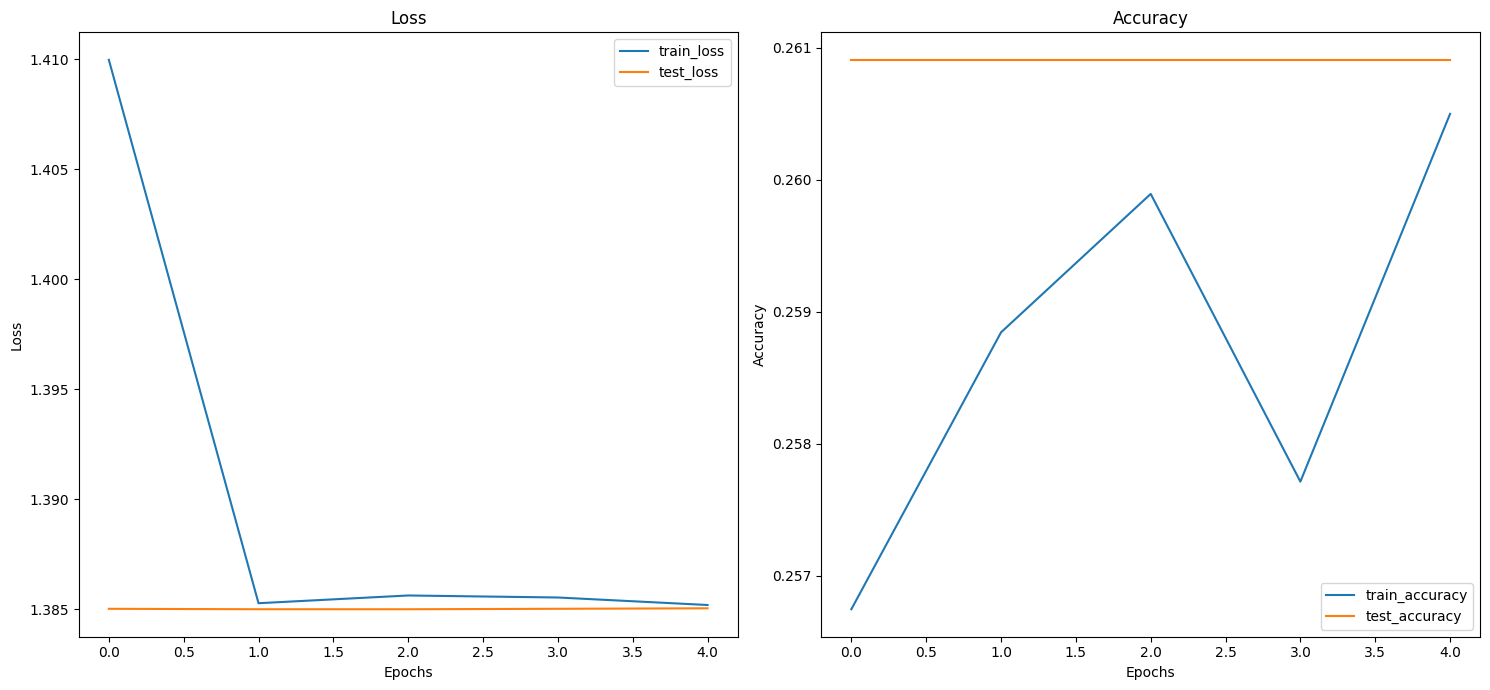

In [ ]:
import torch
from timeit import default_timer as timer
from matplotlib import pyplot as plt

torch.manual_seed(2024)
torch.cuda.manual_seed(2024)  # Applies only to CUDA


# Start the timer
start_time = timer()

# Setup training and save the results
results = train(model1=model1,
                train_dataloader=train_loader,
                test_dataloader=validation_loader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                scheduler=scheduler,
                epochs=5,
                device=device)


# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

# Extract the results for plotting
train_loss = results["train_loss"]
test_loss = results["test_loss"]
train_accuracy = results["train_acc"]
test_accuracy = results["test_acc"]
epochs = range(len(train_loss))


plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs, test_loss, label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label="train_accuracy")
plt.plot(epochs, test_accuracy, label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()



The model perfomance seems to be very poor with an average test accuracy of 0.26. The intial model seems to perfom better.


